In [8]:
import torch
print(torch.__version__)

1.12.0+cpu


In [9]:
class MyCell(torch.nn.Module):
    def __init__(self):
        super(MyCell, self).__init__()
    def forward(self, x, h):
        new_h = torch.tanh(x + h)
        return new_h, new_h
    
my_cell = MyCell()
x = torch.rand(3, 4)
h = torch.rand(3, 4)
print(my_cell(x, h))

(tensor([[0.8760, 0.6129, 0.4367, 0.4553],
        [0.7530, 0.9574, 0.8465, 0.6702],
        [0.8134, 0.7759, 0.3656, 0.7562]]), tensor([[0.8760, 0.6129, 0.4367, 0.4553],
        [0.7530, 0.9574, 0.8465, 0.6702],
        [0.8134, 0.7759, 0.3656, 0.7562]]))


In [11]:
class MyCell(torch.nn.Module):
    def __init__(self):
        super(MyCell, self).__init__()
        self.linear = torch.nn.Linear(4, 4)
    def forward(self, x, h):
        new_h = torch.tanh(self.linear(x) + h)
        return new_h, new_h
mycell = MyCell()
print(mycell)
print(mycell(x, h))

MyCell(
  (linear): Linear(in_features=4, out_features=4, bias=True)
)
(tensor([[0.7803, 0.5152, 0.3687, 0.3173],
        [0.7016, 0.8767, 0.7982, 0.5231],
        [0.6916, 0.8895, 0.2201, 0.6391]], grad_fn=<TanhBackward0>), tensor([[0.7803, 0.5152, 0.3687, 0.3173],
        [0.7016, 0.8767, 0.7982, 0.5231],
        [0.6916, 0.8895, 0.2201, 0.6391]], grad_fn=<TanhBackward0>))


In [12]:
class MyDecisionGate(torch.nn.Module):
    def forward(self, x):
        if x.sum() > 0:
            return x
        else:
            return -x
        
class MyCell(torch.nn.Module):
    def __init__(self):
        super(MyCell, self).__init__()
        self.dg = MyDecisionGate()
        self.linear = torch.nn.Linear(4, 4)
    def forward(self, x, h):
        new_h = torch.tanh(self.dg(self.linear(x)) + h)
        return new_h, new_h
my_cell = MyCell()
print(my_cell)
print(my_cell(x, h))

MyCell(
  (dg): MyDecisionGate()
  (linear): Linear(in_features=4, out_features=4, bias=True)
)
(tensor([[ 0.4228, -0.1690,  0.6431,  0.3314],
        [ 0.0799,  0.3987,  0.8886,  0.5855],
        [ 0.5711,  0.7858,  0.6402,  0.5697]], grad_fn=<TanhBackward0>), tensor([[ 0.4228, -0.1690,  0.6431,  0.3314],
        [ 0.0799,  0.3987,  0.8886,  0.5855],
        [ 0.5711,  0.7858,  0.6402,  0.5697]], grad_fn=<TanhBackward0>))


In [13]:
class MyCell(torch.nn.Module):
    def __init__(self):
        super(MyCell, self).__init__()
        self.linear = torch.nn.Linear(4, 4)
    def forward(self, x, h):
        new_h = torch.tanh(self.linear(x) + h)
        return new_h, new_h
my_cell = MyCell()
x, h = torch.rand(3, 4), torch.rand(3, 4)
traced_cell = torch.jit.trace(my_cell, (x, h))
print(traced_cell)
traced_cell(x, h)

MyCell(
  original_name=MyCell
  (linear): Linear(original_name=Linear)
)


(tensor([[-0.0092,  0.8117,  0.9340,  0.8670],
         [ 0.3464,  0.5834,  0.9217,  0.6657],
         [ 0.6703,  0.8451,  0.9249,  0.8659]], grad_fn=<TanhBackward0>),
 tensor([[-0.0092,  0.8117,  0.9340,  0.8670],
         [ 0.3464,  0.5834,  0.9217,  0.6657],
         [ 0.6703,  0.8451,  0.9249,  0.8659]], grad_fn=<TanhBackward0>))

In [14]:
print(traced_cell.graph)

graph(%self.1 : __torch__.MyCell,
      %x : Float(3, 4, strides=[4, 1], requires_grad=0, device=cpu),
      %h : Float(3, 4, strides=[4, 1], requires_grad=0, device=cpu)):
  %linear : __torch__.torch.nn.modules.linear.Linear = prim::GetAttr[name="linear"](%self.1)
  %20 : Tensor = prim::CallMethod[name="forward"](%linear, %x)
  %11 : int = prim::Constant[value=1]() # <ipython-input-13-a58f1645358a>:6:0
  %12 : Float(3, 4, strides=[4, 1], requires_grad=1, device=cpu) = aten::add(%20, %h, %11) # <ipython-input-13-a58f1645358a>:6:0
  %13 : Float(3, 4, strides=[4, 1], requires_grad=1, device=cpu) = aten::tanh(%12) # <ipython-input-13-a58f1645358a>:6:0
  %14 : (Float(3, 4, strides=[4, 1], requires_grad=1, device=cpu), Float(3, 4, strides=[4, 1], requires_grad=1, device=cpu)) = prim::TupleConstruct(%13, %13)
  return (%14)



In [15]:
print(traced_cell.code)

def forward(self,
    x: Tensor,
    h: Tensor) -> Tuple[Tensor, Tensor]:
  linear = self.linear
  _0 = torch.tanh(torch.add((linear).forward(x, ), h))
  return (_0, _0)



In [16]:
print(my_cell(x, h))
print(traced_cell(x, h))

(tensor([[-0.0092,  0.8117,  0.9340,  0.8670],
        [ 0.3464,  0.5834,  0.9217,  0.6657],
        [ 0.6703,  0.8451,  0.9249,  0.8659]], grad_fn=<TanhBackward0>), tensor([[-0.0092,  0.8117,  0.9340,  0.8670],
        [ 0.3464,  0.5834,  0.9217,  0.6657],
        [ 0.6703,  0.8451,  0.9249,  0.8659]], grad_fn=<TanhBackward0>))
(tensor([[-0.0092,  0.8117,  0.9340,  0.8670],
        [ 0.3464,  0.5834,  0.9217,  0.6657],
        [ 0.6703,  0.8451,  0.9249,  0.8659]], grad_fn=<TanhBackward0>), tensor([[-0.0092,  0.8117,  0.9340,  0.8670],
        [ 0.3464,  0.5834,  0.9217,  0.6657],
        [ 0.6703,  0.8451,  0.9249,  0.8659]], grad_fn=<TanhBackward0>))


In [17]:
class MyDecisionGate(torch.nn.Module):
    def forward(self, x):
        if x.sum() > 0:
            return x
        else:
            return -x
class MyCell(torch.nn.Module):
    def __init__(self, dg):
        super(MyCell, self).__init__()
        self.dg = dg
        self.linear = torch.nn.Linear(4, 4)
    def forward(self, x, h):
        new_h = torch.tanh(self.dg(self.linear(x)) + h)
        return new_h, new_h
my_cell = MyCell(MyDecisionGate())
traced_cell = torch.jit.trace(my_cell, (x, h))
print(traced_cell.dg.code)
print(traced_cell.code)

def forward(self,
    argument_1: Tensor) -> Tensor:
  return torch.neg(argument_1)

def forward(self,
    x: Tensor,
    h: Tensor) -> Tuple[Tensor, Tensor]:
  dg = self.dg
  linear = self.linear
  _0 = torch.add((dg).forward((linear).forward(x, ), ), h)
  _1 = torch.tanh(_0)
  return (_1, _1)



<ipython-input-17-5a4ca2ebf955>:3: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if x.sum() > 0:


In [19]:
scripted_gate = torch.jit.script(MyDecisionGate())
my_cell = MyCell(scripted_gate)
scripted_cell = torch.jit.script(my_cell)

print(scripted_gate.code)
print(scripted_cell.code)

def forward(self,
    x: Tensor) -> Tensor:
  if bool(torch.gt(torch.sum(x), 0)):
    _0 = x
  else:
    _0 = torch.neg(x)
  return _0

def forward(self,
    x: Tensor,
    h: Tensor) -> Tuple[Tensor, Tensor]:
  dg = self.dg
  linear = self.linear
  _0 = torch.add((dg).forward((linear).forward(x, ), ), h)
  new_h = torch.tanh(_0)
  return (new_h, new_h)



In [20]:
x, h = torch.rand(3, 4), torch.rand(3, 4)
traced_cell(x, h)

(tensor([[0.6749, 0.8036, 0.8252, 0.5783],
         [0.1480, 0.6759, 0.6980, 0.7956],
         [0.7718, 0.7208, 0.7639, 0.9150]], grad_fn=<TanhBackward0>),
 tensor([[0.6749, 0.8036, 0.8252, 0.5783],
         [0.1480, 0.6759, 0.6980, 0.7956],
         [0.7718, 0.7208, 0.7639, 0.9150]], grad_fn=<TanhBackward0>))

In [21]:
class MyRNNLoop(torch.nn.Module):
    def __init__(self):
        super(MyRNNLoop, self).__init__()
        self.cell = torch.jit.trace(MyCell(scripted_gate), (x, h))
    def forward(self, xs):
        h, y = torch.zeros(3, 4), torch.zeros(3, 4)
        for i in range(xs.size(0)):
            y, h = self.cell(xs[i], h)
        return y, h
rnn_loop = torch.jit.script(MyRNNLoop())
print(rnn_loop.code)

def forward(self,
    xs: Tensor) -> Tuple[Tensor, Tensor]:
  h = torch.zeros([3, 4])
  y = torch.zeros([3, 4])
  y0 = y
  h0 = h
  for i in range(torch.size(xs, 0)):
    cell = self.cell
    _0 = (cell).forward(torch.select(xs, 0, i), h0, )
    y1, h1, = _0
    y0, h0 = y1, h1
  return (y0, h0)



In [22]:
class WrapRNN(torch.nn.Module):
    def __init__(self):
        super(WrapRNN, self).__init__()
        self.loop = torch.jit.script(MyRNNLoop())
    def forward(self, xs):
        y, h = self.loop(xs)
        return torch.relu(y)
traced = torch.jit.trace(WrapRNN(), (torch.rand(10, 3, 4)))
print(traced.code)

def forward(self,
    xs: Tensor) -> Tensor:
  loop = self.loop
  _0, y, = (loop).forward(xs, )
  return torch.relu(y)



In [23]:
traced.save("wrapped_rnn.pt")
loaded = torch.jit.load('wrapped_rnn.pt')
print(loaded)
print(loaded.code)

RecursiveScriptModule(
  original_name=WrapRNN
  (loop): RecursiveScriptModule(
    original_name=MyRNNLoop
    (cell): RecursiveScriptModule(
      original_name=MyCell
      (dg): RecursiveScriptModule(original_name=MyDecisionGate)
      (linear): RecursiveScriptModule(original_name=Linear)
    )
  )
)
def forward(self,
    xs: Tensor) -> Tensor:
  loop = self.loop
  _0, y, = (loop).forward(xs, )
  return torch.relu(y)



In [24]:
import io
import numpy as np

from torch import nn
import torch.utils.model_zoo as model_zoo
import torch.onnx

In [33]:
import torch.nn as nn
import torch.nn.init as init

class SuperResolutionNet(nn.Module):
    def __init__(self, upscale_factor, inplace=False):
        super(SuperResolutionNet, self).__init__()
        self.relu = nn.ReLU(inplace=inplace)
        self.conv1 = nn.Conv2d(1, 64, (5, 5), (1, 1), (2, 2))
        self.conv2 = nn.Conv2d(64, 64, (3, 3), (1, 1), (1, 1))
        self.conv3 = nn.Conv2d(64, 32, (3, 3), (1, 1), (1, 1))
        self.conv4 = nn.Conv2d(32, upscale_factor ** 2, (3, 3), (1, 1), (1, 1))
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor)
        self._initialize_weights()
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.pixel_shuffle(self.conv4(x))
        return x
    def _initialize_weights(self):
        init.orthogonal_(self.conv1.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv2.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv3.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv4.weight)
torch_model = SuperResolutionNet(upscale_factor=3)

In [34]:
model_url = 'https://s3.amazonaws.com/pytorch/test_data/export/superres_epoch100-44c6958e.pth'
batch_size = 1
map_location = lambda storage, loc: storage
if torch.cuda.is_available():
    map_location = None
torch_model.load_state_dict(model_zoo.load_url(model_url, map_location=map_location))
torch_model.eval()

SuperResolutionNet(
  (relu): ReLU()
  (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 9, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pixel_shuffle): PixelShuffle(upscale_factor=3)
)

In [38]:
# Input to the model
x = torch.randn(batch_size, 1, 224, 224, requires_grad=True)
torch_out = torch_model(x)

# Export the model
torch.onnx.export(torch_model,               # model being run
                  x,                         # model input (or a tuple for multiple inputs)
                  "super_resolution.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=10,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                                'output' : {0 : 'batch_size'}})

In [40]:
import onnx
onnx_model = onnx.load("super_resolution.onnx")
onnx.checker.check_model(onnx_model)

In [42]:
import onnxruntime
ort_session = onnxruntime.InferenceSession("super_resolution.onnx")

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(x)}
ort_outs = ort_session.run(None, ort_inputs)

np.testing.assert_allclose(to_numpy(torch_out), ort_outs[0], rtol=1e-03, atol=1e-05)
print("Exported model has been tested wit onnxruntime and the result looks good!")

Exported model has been tested wit onnxruntime and the result looks good!


In [44]:
from typing import Type, Dict, Any, Tuple, Iterable
import copy
import torch.fx as fx
import torch
import torch.nn as nn

In [45]:
class WrappedBatchNorm(nn.Module):
    def __init__(self):
        super().__init__()
        self.mod = nn.BatchNorm2d(1)
    def forward(self, x):
        return self.mod(x)

class M(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 1, 1)
        self.bn1 = nn.BatchNorm2d(1)
        self.conv2 = nn.Conv2d(1, 1, 1)
        self.nested = nn.Sequential(
            nn.BatchNorm2d(1),
            nn.Conv2d(1, 1, 1),
        )
        self.wrapped = WrappedBatchNorm()

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.conv2(x)
        x = self.nested(x)
        x = self.wrapped(x)
        return x

model = M()

model.eval()

M(
  (conv1): Conv2d(1, 1, kernel_size=(1, 1), stride=(1, 1))
  (bn1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(1, 1, kernel_size=(1, 1), stride=(1, 1))
  (nested): Sequential(
    (0): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Conv2d(1, 1, kernel_size=(1, 1), stride=(1, 1))
  )
  (wrapped): WrappedBatchNorm(
    (mod): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)

In [46]:
traced_model = torch.fx.symbolic_trace(model)
print(traced_model.graph)

graph():
    %x : [#users=1] = placeholder[target=x]
    %conv1 : [#users=1] = call_module[target=conv1](args = (%x,), kwargs = {})
    %bn1 : [#users=1] = call_module[target=bn1](args = (%conv1,), kwargs = {})
    %conv2 : [#users=1] = call_module[target=conv2](args = (%bn1,), kwargs = {})
    %nested_0 : [#users=1] = call_module[target=nested.0](args = (%conv2,), kwargs = {})
    %nested_1 : [#users=1] = call_module[target=nested.1](args = (%nested_0,), kwargs = {})
    %wrapped_mod : [#users=1] = call_module[target=wrapped.mod](args = (%nested_1,), kwargs = {})
    return wrapped_mod


In [47]:
def fuse_conv_bn_eval(conv, bn):
    assert(not (conv.training or bn.training)), "Fusion only for eval!"
    fused_conv = copy.deepcopy(conv)

    fused_conv.weight, fused_conv.bias = \
        fuse_conv_bn_weights(fused_conv.weight, fused_conv.bias,
                             bn.running_mean, bn.running_var, bn.eps, bn.weight, bn.bias)

    return fused_conv

def fuse_conv_bn_weights(conv_w, conv_b, bn_rm, bn_rv, bn_eps, bn_w, bn_b):
    if conv_b is None:
        conv_b = torch.zeros_like(bn_rm)
    if bn_w is None:
        bn_w = torch.ones_like(bn_rm)
    if bn_b is None:
        bn_b = torch.zeros_like(bn_rm)
    bn_var_rsqrt = torch.rsqrt(bn_rv + bn_eps)

    conv_w = conv_w * (bn_w * bn_var_rsqrt).reshape([-1] + [1] * (len(conv_w.shape) - 1))
    conv_b = (conv_b - bn_rm) * bn_var_rsqrt * bn_w + bn_b

    return torch.nn.Parameter(conv_w), torch.nn.Parameter(conv_b)

In [48]:
def _parent_name(target : str) -> Tuple[str, str]:
    *parent, name = target.rsplit('.', 1)
    return parent[0] if parent else '', name

def replace_node_module(node: fx.Node, modules: Dict[str, Any], new_module: torch.nn.Module):
    assert(isinstance(node.target, str))
    parent_name, name = _parent_name(node.target)
    setattr(modules[parent_name], name, new_module)


def fuse(model: torch.nn.Module) -> torch.nn.Module:
    model = copy.deepcopy(model)
    fx_model: fx.GraphModule = fx.symbolic_trace(model)
    modules = dict(fx_model.named_modules())
    for node in fx_model.graph.nodes:
        if node.op != 'call_module': # If our current node isn't calling a Module then we can ignore it.
            continue
        if type(modules[node.target]) is nn.BatchNorm2d and type(modules[node.args[0].target]) is nn.Conv2d:
            if len(node.args[0].users) > 1:  # Output of conv is used by other nodes
                continue
            conv = modules[node.args[0].target]
            bn = modules[node.target]
            fused_conv = fuse_conv_bn_eval(conv, bn)
            replace_node_module(node.args[0], modules, fused_conv)
            node.replace_all_uses_with(node.args[0])
            fx_model.graph.erase_node(node)
    fx_model.graph.lint()
    fx_model.recompile()
    return fx_model

In [49]:
fused_model = fuse(model)
print(fused_model.code)
inp = torch.randn(5, 1, 1, 1)
torch.testing.assert_allclose(fused_model(inp), model(inp))




def forward(self, x):
    conv1 = self.conv1(x);  x = None
    conv2 = self.conv2(conv1);  conv1 = None
    nested_1 = getattr(self.nested, "1")(conv2);  conv2 = None
    return nested_1
    


C:\Users\jatin\anaconda3\lib\site-packages\torch\testing\_deprecated.py:35: FutureWarning: torch.testing.assert_allclose() is deprecated since 1.12 and will be removed in 1.14. Use torch.testing.assert_close() instead. For detailed upgrade instructions see https://github.com/pytorch/pytorch/issues/61844.
  warnings.warn(msg, FutureWarning)


In [50]:
import torchvision.models as models
import time

rn18 = models.resnet18()
rn18.eval()

inp = torch.randn(10, 3, 224, 224)
output = rn18(inp)

def benchmark(model, iters=20):
    for _ in range(10):
        model(inp)
    begin = time.time()
    for _ in range(iters):
        model(inp)
    return str(time.time()-begin)

fused_rn18 = fuse(rn18)
print("Unfused time: ", benchmark(rn18))
print("Fused time: ", benchmark(fused_rn18))

Unfused time:  12.660768985748291
Fused time:  11.736673831939697


In [51]:
jit_rn18 = torch.jit.script(fused_rn18)
print("jit time: ", benchmark(jit_rn18))


############
# Conclusion
# ----------
# As we can see, using FX we can easily write static graph transformations on
# PyTorch code.
#
# Since FX is still in beta, we would be happy to hear any
# feedback you have about using it. Please feel free to use the
# PyTorch Forums (https://discuss.pytorch.org/) and the issue tracker
# (https://github.com/pytorch/pytorch/issues) to provide any feedback
# you might have.

jit time:  12.971623659133911


In [52]:
import torch
import torch.fx
import torchvision.models as models

rn18 = models.resnet18()
rn18.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [53]:
input = torch.randn(5, 3, 224, 224)
output = rn18(input)

In [55]:
import statistics, tabulate, time
from typing import Any, Dict, List
from torch.fx import Interpreter

In [56]:
traced_rn18 = torch.fx.symbolic_trace(rn18)
print(traced_rn18.graph)

graph():
    %x : torch.Tensor [#users=1] = placeholder[target=x]
    %conv1 : [#users=1] = call_module[target=conv1](args = (%x,), kwargs = {})
    %bn1 : [#users=1] = call_module[target=bn1](args = (%conv1,), kwargs = {})
    %relu : [#users=1] = call_module[target=relu](args = (%bn1,), kwargs = {})
    %maxpool : [#users=2] = call_module[target=maxpool](args = (%relu,), kwargs = {})
    %layer1_0_conv1 : [#users=1] = call_module[target=layer1.0.conv1](args = (%maxpool,), kwargs = {})
    %layer1_0_bn1 : [#users=1] = call_module[target=layer1.0.bn1](args = (%layer1_0_conv1,), kwargs = {})
    %layer1_0_relu : [#users=1] = call_module[target=layer1.0.relu](args = (%layer1_0_bn1,), kwargs = {})
    %layer1_0_conv2 : [#users=1] = call_module[target=layer1.0.conv2](args = (%layer1_0_relu,), kwargs = {})
    %layer1_0_bn2 : [#users=1] = call_module[target=layer1.0.bn2](args = (%layer1_0_conv2,), kwargs = {})
    %add : [#users=1] = call_function[target=operator.add](args = (%layer1_0_bn2,

In [60]:
class ProfilingInterpreter(Interpreter):
    def __init__(self, mod : torch.nn.Module):
        # Rather than have the user symbolically trace their model,
        # we're going to do it in the constructor. As a result, the
        # user can pass in any ``Module`` without having to worry about
        # symbolic tracing APIs
        gm = torch.fx.symbolic_trace(mod)
        super().__init__(gm)

        # We are going to store away two things here:
        #
        # 1. A list of total runtimes for ``mod``. In other words, we are
        #    storing away the time ``mod(...)`` took each time this
        #    interpreter is called.
        self.total_runtime_sec : List[float] = []
        # 2. A map from ``Node`` to a list of times (in seconds) that
        #    node took to run. This can be seen as similar to (1) but
        #    for specific sub-parts of the model.
        self.runtimes_sec : Dict[torch.fx.Node, List[float]] = {}

    ######################################################################
    # Next, let's override our first method: ``run()``. ``Interpreter``'s ``run``
    # method is the top-level entrypoint for execution of the model. We will
    # want to intercept this so that we can record the total runtime of the
    # model.

    def run(self, *args) -> Any:
        # Record the time we started running the model
        t_start = time.time()
        # Run the model by delegating back into Interpreter.run()
        return_val = super().run(*args)
        # Record the time we finished running the model
        t_end = time.time()
        # Store the total elapsed time this model execution took in the
        # ProfilingInterpreter
        self.total_runtime_sec.append(t_end - t_start)
        return return_val

    ######################################################################
    # Now, let's override ``run_node``. ``Interpreter`` calls ``run_node`` each
    # time it executes a single node. We will intercept this so that we
    # can measure and record the time taken for each individual call in
    # the model.

    def run_node(self, n : torch.fx.Node) -> Any:
        # Record the time we started running the op
        t_start = time.time()
        # Run the op by delegating back into Interpreter.run_node()
        return_val = super().run_node(n)
        # Record the time we finished running the op
        t_end = time.time()
        # If we don't have an entry for this node in our runtimes_sec
        # data structure, add one with an empty list value.
        self.runtimes_sec.setdefault(n, [])
        # Record the total elapsed time for this single invocation
        # in the runtimes_sec data structure
        self.runtimes_sec[n].append(t_end - t_start)
        return return_val

    ######################################################################
    # Finally, we are going to define a method (one which doesn't override
    # any ``Interpreter`` method) that provides us a nice, organized view of
    # the data we have collected.

    def summary(self, should_sort : bool = False) -> str:
        # Build up a list of summary information for each node
        node_summaries : List[List[Any]] = []
        # Calculate the mean runtime for the whole network. Because the
        # network may have been called multiple times during profiling,
        # we need to summarize the runtimes. We choose to use the
        # arithmetic mean for this.
        mean_total_runtime = statistics.mean(self.total_runtime_sec)

        # For each node, record summary statistics
        for node, runtimes in self.runtimes_sec.items():
            # Similarly, compute the mean runtime for ``node``
            mean_runtime = statistics.mean(runtimes)
            # For easier understanding, we also compute the percentage
            # time each node took with respect to the whole network.
            pct_total = mean_runtime / mean_total_runtime * 100
            # Record the node's type, name of the node, mean runtime, and
            # percent runtim
            node_summaries.append(
                [node.op, str(node), mean_runtime, pct_total])

        # One of the most important questions to answer when doing performance
        # profiling is "Which op(s) took the longest?". We can make this easy
        # to see by providing sorting functionality in our summary view
        if should_sort:
            node_summaries.sort(key=lambda s: s[2], reverse=True)

        # Use the ``tabulate`` library to create a well-formatted table
        # presenting our summary information
        headers : List[str] = [
            'Op type', 'Op', 'Average runtime (s)', 'Pct total runtime'
        ]
        return tabulate.tabulate(node_summaries, headers=headers)

In [61]:
interp = ProfilingInterpreter(rn18)
interp.run(input)
print(interp.summary(True))

Op type        Op                       Average runtime (s)    Pct total runtime
-------------  ---------------------  ---------------------  -------------------
call_module    maxpool                          0.033864                8.03035
call_module    conv1                            0.0312502               7.41053
call_module    layer4_1_conv2                   0.0231104               5.48029
call_module    layer4_1_conv1                   0.0230913               5.47576
call_module    layer1_0_conv1                   0.0219407               5.20291
call_module    layer4_0_conv2                   0.021754                5.15864
call_module    layer1_1_conv2                   0.020967                4.97201
call_module    layer1_0_conv2                   0.0203085               4.81586
call_module    layer1_1_conv1                   0.0185938               4.40924
call_module    layer3_1_conv1                   0.0184429               4.37345
call_module    layer3_1_conv2         

In [62]:
import torch
N, C, H, W = 10, 3, 32, 32
x = torch.empty(N, C, H, W)
print(x.stride())

(3072, 1024, 32, 1)


In [63]:
x = x.to(memory_format=torch.channels_last)
print(x.shape)
print(x.stride())

torch.Size([10, 3, 32, 32])
(3072, 1, 96, 3)


In [66]:
x = x.to(memory_format=torch.contiguous_format)
print(x.stride())

(3072, 1024, 32, 1)


In [67]:
x = x.contiguous(memory_format=torch.channels_last)
print(x.stride())

(3072, 1, 96, 3)


In [68]:
print(x.is_contiguous(memory_format=torch.channels_last))

True


In [69]:
special_x = torch.empty(4, 1, 4, 4)
print(special_x.is_contiguous(memory_format=torch.channels_last))
print(special_x.is_contiguous(memory_format=torch.contiguous_format))

True
True


In [70]:
x = torch.empty(N, C, H, W, memory_format=torch.channels_last)
print(x.stride())

(3072, 1, 96, 3)


In [71]:
y = x.clone()
print(y.stride())

(3072, 1, 96, 3)


In [72]:
if torch.cuda.is_available():
    y = x.cuda()
    print(y.stride())

In [73]:
y = torch.empty_like(x)
print(y.stride())

(3072, 1, 96, 3)


In [74]:
z = x + y
print(z.stride())

(3072, 1, 96, 3)


In [77]:
def contains_cl(args):
    for t in args:
        if isinstance(t, torch.Tensor):
            if t.is_contiguous(memory_format=torch.channels_last) and not t.is_contiguous():
                return True
        elif isinstance(t, list) or isinstance(t, tuple):
            if contains_cl(list(t)):
                return True
    return False


def print_inputs(args, indent=""):
    for t in args:
        if isinstance(t, torch.Tensor):
            print(indent, t.stride(), t.shape, t.device, t.dtype)
        elif isinstance(t, list) or isinstance(t, tuple):
            print(indent, type(t))
            print_inputs(list(t), indent=indent + "    ")
        else:
            print(indent, t)


def check_wrapper(fn):
    name = fn.__name__

    def check_cl(*args, **kwargs):
        was_cl = contains_cl(args)
        try:
            result = fn(*args, **kwargs)
        except Exception as e:
            print("`{}` inputs are:".format(name))
            print_inputs(args)
            print("-------------------")
            raise e
        failed = False
        if was_cl:
            if isinstance(result, torch.Tensor):
                if result.dim() == 4 and not result.is_contiguous(memory_format=torch.channels_last):
                    print(
                        "`{}` got channels_last input, but output is not channels_last:".format(name),
                        result.shape,
                        result.stride(),
                        result.device,
                        result.dtype,
                    )
                    failed = True
        if failed and True:
            print("`{}` inputs are:".format(name))
            print_inputs(args)
            raise Exception("Operator `{}` lost channels_last property".format(name))
        return result

    return check_cl


old_attrs = dict()


def attribute(m):
    old_attrs[m] = dict()
    for i in dir(m):
        e = getattr(m, i)
        exclude_functions = ["is_cuda", "has_names", "numel", "stride", "Tensor", "is_contiguous", "__class__"]
        if i not in exclude_functions and not i.startswith("_") and "__call__" in dir(e):
            try:
                old_attrs[m][i] = e
                setattr(m, i, check_wrapper(e))
            except Exception as e:
                print(i)
                print(e)


attribute(torch.Tensor)
attribute(torch.nn.functional)
attribute(torch)

Callable
__name__
List
__name__
Optional
'_SpecialForm' object has no attribute '__name__'
Tuple
__name__
Union
'_SpecialForm' object has no attribute '__name__'
Callable
__name__
Set
__name__
Union
'_SpecialForm' object has no attribute '__name__'


In [78]:
for (m, attrs) in old_attrs.items():
    for (k, v) in attrs.items():
        setattr(m, k, v)

In [79]:
import torch
def foo(x):
    return torch.neg(x)

@torch.jit.script
def example(x):
    future = torch.jit.fork(foo, x)
    x_normal = foo(x)
    x_parallel = torch.jit.wait(future)
    return x_normal, x_parallel
print(example(torch.ones(1)))

(tensor([-1.]), tensor([-1.]))


In [81]:
import torch
from typing import List

def foo(x):
    return torch.neg(x)

@torch.jit.script
def example(x):
    futures : List[torch.jit.Future[torch.Tensor]] = []
    for _ in range(100):
        futures.append(torch.jit.fork(foo, x))

    results = []
    for future in futures:
        results.append(torch.jit.wait(future))

    return torch.sum(torch.stack(results))

print(example(torch.ones([])))

tensor(-100.)


In [82]:
import torch, time

# In RNN parlance, the dimensions we care about are:
# # of time-steps (T)
# Batch size (B)
# Hidden size/number of "channels" (C)
T, B, C = 50, 50, 1024

# A module that defines a single "bidirectional LSTM". This is simply two
# LSTMs applied to the same sequence, but one in reverse
class BidirectionalRecurrentLSTM(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.cell_f = torch.nn.LSTM(input_size=C, hidden_size=C)
        self.cell_b = torch.nn.LSTM(input_size=C, hidden_size=C)

    def forward(self, x : torch.Tensor) -> torch.Tensor:
        # Forward layer
        output_f, _ = self.cell_f(x)

        # Backward layer. Flip input in the time dimension (dim 0), apply the
        # layer, then flip the outputs in the time dimension
        x_rev = torch.flip(x, dims=[0])
        output_b, _ = self.cell_b(torch.flip(x, dims=[0]))
        output_b_rev = torch.flip(output_b, dims=[0])

        return torch.cat((output_f, output_b_rev), dim=2)


# An "ensemble" of `BidirectionalRecurrentLSTM` modules. The modules in the
# ensemble are run one-by-one on the same input then their results are
# stacked and summed together, returning the combined result.
class LSTMEnsemble(torch.nn.Module):
    def __init__(self, n_models):
        super().__init__()
        self.n_models = n_models
        self.models = torch.nn.ModuleList([
            BidirectionalRecurrentLSTM() for _ in range(self.n_models)])

    def forward(self, x : torch.Tensor) -> torch.Tensor:
        results = []
        for model in self.models:
            results.append(model(x))
        return torch.stack(results).sum(dim=0)

# For a head-to-head comparison to what we're going to do with fork/wait, let's
# instantiate the model and compile it with TorchScript
ens = torch.jit.script(LSTMEnsemble(n_models=4))

# Normally you would pull this input out of an embedding table, but for the
# purpose of this demo let's just use random data.
x = torch.rand(T, B, C)

# Let's run the model once to warm up things like the memory allocator
ens(x)

x = torch.rand(T, B, C)

# Let's see how fast it runs!
s = time.time()
ens(x)
print('Inference took', time.time() - s, ' seconds')

Inference took 6.19237756729126  seconds


In [83]:
def forward(self, x : torch.Tensor) -> torch.Tensor:
    # Forward layer - fork() so this can run in parallel to the backward
    # layer
    future_f = torch.jit.fork(self.cell_f, x)

    # Backward layer. Flip input in the time dimension (dim 0), apply the
    # layer, then flip the outputs in the time dimension
    x_rev = torch.flip(x, dims=[0])
    output_b, _ = self.cell_b(torch.flip(x, dims=[0]))
    output_b_rev = torch.flip(output_b, dims=[0])

    # Retrieve the output from the forward layer. Note this needs to happen
    # *after* the stuff we want to parallelize with
    output_f, _ = torch.jit.wait(future_f)

    return torch.cat((output_f, output_b_rev), dim=2)

In [85]:
with torch.autograd.profiler.profile() as prof:
    ens(x)
prof.export_chrome_trace('parallel.json')

In [86]:
def forward(self, x : torch.Tensor) -> torch.Tensor:
    # Launch tasks for each model
    futures : List[torch.jit.Future[torch.Tensor]] = []
    for model in self.models:
        futures.append(torch.jit.fork(model, x))

    # Collect the results from the launched tasks
    results : List[torch.Tensor] = []
    for future in futures:
        results.append(torch.jit.wait(future))

    return torch.stack(results).sum(dim=0)

In [87]:
def forward(self, x : torch.Tensor) -> torch.Tensor:
    futures = [torch.jit.fork(model, x) for model in self.models]
    results = [torch.jit.wait(fut) for fut in futures]
    return torch.stack(results).sum(dim=0)

In [88]:
start_x = 1
gpu_mem = 128

In [89]:
import cv2
from PIL import Image

cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 224)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 224)
cap.set(cv2.CAP_PROP_FPS, 36)

True

In [90]:
ret, image = cap.read()
image = image[:, :, [2, 1, 0]]

In [93]:
from torchvision import transforms
preprocess = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                                             std=[0.229, 0.224, 0.225])])
input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)

In [1]:
import torch

class Square(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        # Because we are saving one of the inputs use `save_for_backward`
        # Save non-tensors and non-inputs/non-outputs directly on ctx
        ctx.save_for_backward(x)
        return x**2

    @staticmethod
    def backward(ctx, grad_out):
        # A function support double backward automatically if autograd
        # is able to record the computations performed in backward
        x, = ctx.saved_tensors
        return grad_out * 2 * x

# Use double precision because finite differencing method magnifies errors
x = torch.rand(3, 3, requires_grad=True, dtype=torch.double)
torch.autograd.gradcheck(Square.apply, x)
# Use gradcheck to verify second-order derivatives
torch.autograd.gradgradcheck(Square.apply, x)

True

In [4]:
class Exp(torch.autograd.Function):
    # Simple case where everything goes well
    @staticmethod
    def forward(ctx, x):
        # This time we save the output
        result = torch.exp(x)
        # Note that we should use `save_for_backward` here when
        # the tensor saved is an ouptut (or an input).
        ctx.save_for_backward(result)
        return result

    @staticmethod
    def backward(ctx, grad_out):
        result, = ctx.saved_tensors
        return result * grad_out

x = torch.tensor(1., requires_grad=True, dtype=torch.double).clone()
# Validate our gradients using gradcheck
torch.autograd.gradcheck(Exp.apply, x)
torch.autograd.gradgradcheck(Exp.apply, x)

True

In [5]:
class Sinh(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        expx = torch.exp(x)
        expnegx = torch.exp(-x)
        ctx.save_for_backward(expx, expnegx)
        # In order to be able to save the intermediate results, a trick is to
        # include them as our outputs, so that the backward graph is constructed
        return (expx - expnegx) / 2, expx, expnegx

    @staticmethod
    def backward(ctx, grad_out, _grad_out_exp, _grad_out_negexp):
        expx, expnegx = ctx.saved_tensors
        grad_input = grad_out * (expx + expnegx) / 2
        # We cannot skip accumulating these even though we won't use the outputs
        # directly. They will be used later in the second backward.
        grad_input += _grad_out_exp * expx
        grad_input -= _grad_out_negexp * expnegx
        return grad_input

def sinh(x):
    # Create a wrapper that only returns the first output
    return Sinh.apply(x)[0]

x = torch.rand(3, 3, requires_grad=True, dtype=torch.double)
torch.autograd.gradcheck(sinh, x)
torch.autograd.gradgradcheck(sinh, x)

True

In [6]:
class SinhBad(torch.autograd.Function):
    # This is an example of what NOT to do!
    @staticmethod
    def forward(ctx, x):
        expx = torch.exp(x)
        expnegx = torch.exp(-x)
        ctx.expx = expx
        ctx.expnegx = expnegx
        return (expx - expnegx) / 2

    @staticmethod
    def backward(ctx, grad_out):
        expx = ctx.expx
        expnegx = ctx.expnegx
        grad_input = grad_out * (expx + expnegx) / 2
        return grad_input

In [7]:
def cube_forward(x):
    return x**3

def cube_backward(grad_out, x):
    return grad_out * 3 * x**2

def cube_backward_backward(grad_out, sav_grad_out, x):
    return grad_out * sav_grad_out * 6 * x

def cube_backward_backward_grad_out(grad_out, x):
    return grad_out * 3 * x**2

class Cube(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        ctx.save_for_backward(x)
        return cube_forward(x)

    @staticmethod
    def backward(ctx, grad_out):
        x, = ctx.saved_tensors
        return CubeBackward.apply(grad_out, x)

class CubeBackward(torch.autograd.Function):
    @staticmethod
    def forward(ctx, grad_out, x):
        ctx.save_for_backward(x, grad_out)
        return cube_backward(grad_out, x)

    @staticmethod
    def backward(ctx, grad_out):
        x, sav_grad_out = ctx.saved_tensors
        dx = cube_backward_backward(grad_out, sav_grad_out, x)
        dgrad_out = cube_backward_backward_grad_out(grad_out, x)
        return dgrad_out, dx

x = torch.tensor(2., requires_grad=True, dtype=torch.double)

torch.autograd.gradcheck(Cube.apply, x)
torch.autograd.gradgradcheck(Cube.apply, x)

True

In [8]:
import torch
from torch.autograd.function import once_differentiable
import torch.nn.functional as F

def convolution_backward(grad_out, X, weight):
    grad_input = F.conv2d(X.transpose(0, 1), grad_out.transpose(0, 1)).transpose(0, 1)
    grad_X = F.conv_transpose2d(grad_out, weight)
    return grad_X, grad_input

class Conv2D(torch.autograd.Function):
    @staticmethod
    def forward(ctx, X, weight):
        ctx.save_for_backward(X, weight)
        return F.conv2d(X, weight)

    # Use @once_differentiable by default unless we intend to double backward
    @staticmethod
    @once_differentiable
    def backward(ctx, grad_out):
        X, weight = ctx.saved_tensors
        return convolution_backward(grad_out, X, weight)

In [9]:
weight = torch.rand(5, 3, 3, 3, requires_grad=True, dtype=torch.double)
X = torch.rand(10, 3, 7, 7, requires_grad=True, dtype=torch.double)
torch.autograd.gradcheck(Conv2D.apply, (X, weight))

True

In [10]:
def unsqueeze_all(t):
    return t[None, :, None, None]

def batch_norm_backward(grad_out, X, sum, sqrt_var, N, eps):
    tmp = ((X - unsqueeze_all(sum) / N) * grad_out).sum(dim=(0, 2, 3))
    tmp *= -1
    d_denom = tmp / (sqrt_var + eps)**2 
    d_var = d_denom / (2 * sqrt_var)
    d_mean_dx = grad_out / unsqueeze_all(sqrt_var + eps)
    d_mean_dx = unsqueeze_all(-d_mean_dx.sum(dim=(0, 2, 3)) / N)
    grad_input = X * unsqueeze_all(d_var * N)
    grad_input += unsqueeze_all(-d_var * sum)
    grad_input *= 2 / ((N - 1) * N)
    grad_input += d_mean_dx
    grad_input *= unsqueeze_all(sqrt_var + eps)
    grad_input += grad_out
    grad_input /= unsqueeze_all(sqrt_var + eps)  # sqrt_var + eps > 0!
    return grad_input

class BatchNorm(torch.autograd.Function):
    @staticmethod
    def forward(ctx, X, eps=1e-3):
        sum = X.sum(dim=(0, 2, 3))
        var = X.var(unbiased=True, dim=(0, 2, 3))
        N = X.numel() / X.size(1)
        sqrt_var = torch.sqrt(var)
        ctx.save_for_backward(X)
        ctx.eps = eps
        ctx.sum = sum
        ctx.N = N
        ctx.sqrt_var = sqrt_var
        mean = sum / N
        denom = sqrt_var + eps
        out = X - unsqueeze_all(mean)
        out /= unsqueeze_all(denom)
        return out

    @staticmethod
    @once_differentiable
    def backward(ctx, grad_out):
        X, = ctx.saved_tensors
        return batch_norm_backward(grad_out, X, ctx.sum, ctx.sqrt_var, ctx.N, ctx.eps)

In [11]:
a = torch.rand(1, 2, 3, 4, requires_grad=True, dtype=torch.double)
torch.autograd.gradcheck(BatchNorm.apply, (a,), fast_mode=False)

True

In [12]:
class FusedConvBN2DFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, X, conv_weight, eps=1e-3):
        assert X.ndim == 4  # N, C, H, W
        # (1) Only need to save this single buffer for backward!
        ctx.save_for_backward(X, conv_weight)

        # (2) Exact same Conv2D forward from example above
        X = F.conv2d(X, conv_weight)
        # (3) Exact same BatchNorm2D forward from example above
        sum = X.sum(dim=(0, 2, 3))
        var = X.var(unbiased=True, dim=(0, 2, 3))
        N = X.numel() / X.size(1)
        sqrt_var = torch.sqrt(var)
        ctx.eps = eps
        ctx.sum = sum
        ctx.N = N
        ctx.sqrt_var = sqrt_var
        mean = sum / N
        denom = sqrt_var + eps
        # Try to do as many things in-place as possible
        # Instead of `out = (X - a) / b`, doing `out = X - a; out /= b`
        # avoids allocating one extra NCHW-sized buffer here
        out = X - unsqueeze_all(mean)
        out /= unsqueeze_all(denom)
        return out

    @staticmethod
    def backward(ctx, grad_out):
        X, conv_weight, = ctx.saved_tensors
        # (4) Batch norm backward
        # (5) We need to recompute conv
        X_conv_out = F.conv2d(X, conv_weight)
        grad_out = batch_norm_backward(grad_out, X_conv_out, ctx.sum, ctx.sqrt_var,
                                       ctx.N, ctx.eps)
        # (6) Conv2d backward
        grad_X, grad_input = convolution_backward(grad_out, X, conv_weight)
        return grad_X, grad_input, None, None, None, None, None

In [13]:
import torch.nn as nn
import math

class FusedConvBN(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, exp_avg_factor=0.1,
                 eps=1e-3, device=None, dtype=None):
        super(FusedConvBN, self).__init__()
        factory_kwargs = {'device': device, 'dtype': dtype}
        # Conv parameters
        weight_shape = (out_channels, in_channels, kernel_size, kernel_size)
        self.conv_weight = nn.Parameter(torch.empty(*weight_shape, **factory_kwargs))
        # Batch norm parameters
        num_features = out_channels
        self.num_features = num_features
        self.eps = eps
        # Initialize
        self.reset_parameters()

    def forward(self, X):
        return FusedConvBN2DFunction.apply(X, self.conv_weight, self.eps)

    def reset_parameters(self) -> None:
        nn.init.kaiming_uniform_(self.conv_weight, a=math.sqrt(5))

In [14]:
weight = torch.rand(5, 3, 3, 3, requires_grad=True, dtype=torch.double)
X = torch.rand(2, 3, 4, 4, requires_grad=True, dtype=torch.double)
torch.autograd.gradcheck(FusedConvBN2DFunction.apply, (X, weight))

True

In [16]:
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

# Record memory allocated at the end of the forward pass
memory_allocated = [[],[]]

class Net(nn.Module):
    def __init__(self, fused=True):
        super(Net, self).__init__()
        self.fused = fused
        if fused:
            self.convbn1 = FusedConvBN(1, 32, 3)
            self.convbn2 = FusedConvBN(32, 64, 3)
        else:
            self.conv1 = nn.Conv2d(1, 32, 3, 1, bias=False)
            self.bn1 = nn.BatchNorm2d(32, affine=False, track_running_stats=False)
            self.conv2 = nn.Conv2d(32, 64, 3, 1, bias=False)
            self.bn2 = nn.BatchNorm2d(64, affine=False, track_running_stats=False)
        self.fc1 = nn.Linear(9216, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        if self.fused:
            x = self.convbn1(x)
        else:
            x = self.conv1(x)
            x = self.bn1(x)
        F.relu_(x)
        if self.fused:
            x = self.convbn2(x)
        else:
            x = self.conv2(x)
            x = self.bn2(x)
        F.relu_(x)
        x = F.max_pool2d(x, 2)
        F.relu_(x)
        x = x.flatten(1)
        x = self.fc1(x)
        x = self.dropout(x)
        F.relu_(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        if fused:
            memory_allocated[0].append(torch.cuda.memory_allocated())
        else:
            memory_allocated[1].append(torch.cuda.memory_allocated())
        return output

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 2 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    # Use inference mode instead of no_grad, for free improved test-time performance
    with torch.inference_mode():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            # sum up batch loss
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            # get the index of the max log-probability
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
train_kwargs = {'batch_size': 2048}
test_kwargs = {'batch_size': 2048}

if use_cuda:
    cuda_kwargs = {'num_workers': 1,
                   'pin_memory': True,
                   'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
dataset1 = datasets.MNIST('/data', train=True, download=True,
                          transform=transform)
dataset2 = datasets.MNIST('/data', train=False,
                          transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1, **train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /data\MNIST\raw\train-images-idx3-ubyte.gz to /data\MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /data\MNIST\raw\train-labels-idx1-ubyte.gz to /data\MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /data\MNIST\raw\t10k-images-idx3-ubyte.gz to /data\MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /data\MNIST\raw\t10k-labels-idx1-ubyte.gz to /data\MNIST\raw



In [17]:
from statistics import mean

torch.backends.cudnn.enabled = True

if use_cuda:
    peak_memory_allocated = []

    for fused in (True, False):
        torch.manual_seed(123456)

        model = Net(fused=fused).to(device)
        optimizer = optim.Adadelta(model.parameters(), lr=1.0)
        scheduler = StepLR(optimizer, step_size=1, gamma=0.7)

        for epoch in range(1):
            train(model, device, train_loader, optimizer, epoch)
            test(model, device, test_loader)
            scheduler.step()
        peak_memory_allocated.append(torch.cuda.max_memory_allocated())
        torch.cuda.reset_peak_memory_stats()
    print("CuDNN version:", torch.backends.cudnn.version())
    print()
    print("Peak memory allocated:")
    print(f"fused: {peak_memory_allocated[0]/1024**3:.2f}GB, unfused: {peak_memory_allocated[1]/1024**3:.2f}GB")
    print("Memory allocated at end of forward pass:")
    print(f"fused: {mean(memory_allocated[0])/1024**3:.2f}GB, unfused: {mean(memory_allocated[1])/1024**3:.2f}GB")

In [18]:
import torch
import torch.autograd.forward_ad as fwAD

primal = torch.randn(10, 10)
tangent = torch.randn(10, 10)

def fn(x, y):
    return x ** 2 + y ** 2
with fwAD.dual_level():
    dual_input = fwAD.make_dual(primal, tangent)
    assert fwAD.unpack_dual(dual_input).tangent is tangent
    dual_input_alt = fwAD.make_dual(primal, tangent.T)
    assert fwAD.unpack_dual(dual_input_alt).tangent is not tangent
    plain_tensor = torch.randn(10, 10)
    dual_output = fn(dual_input, plain_tensor)
    jvp = fwAD.unpack_dual(dual_output).tangent

assert fwAD.unpack_dual(dual_output).tangent is None

In [19]:
import torch.nn as nn

model = nn.Linear(5, 5)
input = torch.randn(16, 5)

params = {name: p for name, p in model.named_parameters()}
tangents = {name: torch.rand_like(p) for name, p in params.items()}

with fwAD.dual_level():
    for name, p in params.items():
        delattr(model, name)
        setattr(model, name, fwAD.make_dual(p, tangents[name]))

    out = model(input)
    jvp = fwAD.unpack_dual(out).tangent

In [20]:
from torch.nn.utils._stateless import functional_call

# We need a fresh module because the functional call requires the
# the model to have parameters registered.
model = nn.Linear(5, 5)

dual_params = {}
with fwAD.dual_level():
    for name, p in params.items():
        # Using the same ``tangents`` from the above section
        dual_params[name] = fwAD.make_dual(p, tangents[name])
    out = functional_call(model, dual_params, input)
    jvp2 = fwAD.unpack_dual(out).tangent

# Check our results
assert torch.allclose(jvp, jvp2)

In [21]:
class Fn(torch.autograd.Function):
    @staticmethod
    def forward(ctx, foo):
        result = torch.exp(foo)
        # Tensors stored in ctx can be used in the subsequent forward grad
        # computation.
        ctx.result = result
        return result

    @staticmethod
    def jvp(ctx, gI):
        gO = gI * ctx.result
        # If the tensor stored in ctx will not also be used in the backward pass,
        # one can manually free it using ``del``
        del ctx.result
        return gO

fn = Fn.apply

primal = torch.randn(10, 10, dtype=torch.double, requires_grad=True)
tangent = torch.randn(10, 10)

with fwAD.dual_level():
    dual_input = fwAD.make_dual(primal, tangent)
    dual_output = fn(dual_input)
    jvp = fwAD.unpack_dual(dual_output).tangent
torch.autograd.gradcheck(Fn.apply, (primal,), check_forward_ad=True,
                         check_backward_ad=False, check_undefined_grad=False,
                         check_batched_grad=False)

True

In [23]:
import functorch as ft

primal0 = torch.randn(10, 10)
tangent0 = torch.randn(10, 10)
primal1 = torch.randn(10, 10)
tangent1 = torch.randn(10, 10)

def fn(x, y):
    return x ** 2 + y ** 2

# Here is a basic example to compute the JVP of the above function.
# The jvp(func, primals, tangents) returns func(*primals) as well as the
# computed jvp. Each primal must be associated with a tangent of the same shape.
primal_out, tangent_out = ft.jvp(fn, (primal0, primal1), (tangent0, tangent1))

# functorch.jvp requires every primal to be associated with a tangent.
# If we only want to associate certain inputs to `fn` with tangents,
# then we'll need to create a new function that captures inputs without tangents:
primal = torch.randn(10, 10)
tangent = torch.randn(10, 10)
y = torch.randn(10, 10)

import functools
new_fn = functools.partial(fn, y=y)
primal_out, tangent_out = ft.jvp(new_fn, (primal,), (tangent,))

In [24]:
model = nn.Linear(5, 5)
input = torch.randn(16, 5)
tangents = tuple([torch.rand_like(p) for p in model.parameters()])

# Given a torch.nn.Module, ft.make_functional_with_buffers extracts the state
# (params and buffers) and returns a functional version of the model that
# can be invoked like a function.
# That is, the returned ``func`` can be invoked like
# ``func(params, buffers, input)``.
# ft.make_functional_with_buffers is analogous to the nn.Modules stateless API
# that you saw previously and we're working on consolidating the two.
func, params, buffers = ft.make_functional_with_buffers(model)

# Because jvp requires every input to be associated with a tangent, we need to
# create a new function that, when given the parameters, produces the output
def func_params_only(params):
    return func(params, buffers, input)

model_output, jvp_out = ft.jvp(func_params_only, (params,), (tangents,))

# profiling

In [1]:
import torch
import numpy as np
from torch import nn
import torch.autograd.profiler as profiler

In [2]:
class MyModule(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super(MyModule, self).__init__()
        self.linear = nn.Linear(in_features, out_features, bias)
    def forward(self, input, mask):
        with profiler.record_function("LINEAR PASS"):
            out = self.linear(input)
        with profiler.record_function("MASK INDICES"):
            threshold = out.sum(axis=1).mean().item()
            hi_idx = np.argwhere(mask.cpu().numpy() > threshold)
            hi_idx = torch.from_numpy(hi_idx).cpu()
        return out, hi_idx

In [3]:
model = MyModule(500, 10).cpu()
input = torch.rand(128, 500).cpu()
mask = torch.rand((500, 500, 500), dtype=torch.double).cpu()

model(input, mask)

with profiler.profile(with_stack=True, profile_memory=True) as prof:
    out, idx = model(input, mask)

In [4]:
print(prof.key_averages(group_by_stack_n=5).table(sort_by='self_cpu_time_total', row_limit=5))

-----------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ---------------------------------------------------------------------------  
                         Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  Source Location                                                              
-----------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ---------------------------------------------------------------------------  
                 MASK INDICES        99.61%       26.493s        99.69%       26.514s       26.514s          -4 b        -808 b             1  anaconda3\lib\runpy.py(87): _run_code                                        
                                                                                                                    

In [7]:
model = MyModule(500, 10).cpu()
input = torch.rand(128, 500).cpu()
mask = torch.rand((500, 500, 500), dtype=torch.float).cpu()

model(input, mask)

with profiler.profile(with_stack=True, profile_memory=True) as prof:
    out, idx = model(input, mask)
print(prof.key_averages(group_by_stack_n=5).table(sort_by="self_cpu_time_total", row_limit=5))

-----------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ---------------------------------------------------------------------------  
                         Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  Source Location                                                              
-----------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ---------------------------------------------------------------------------  
                 MASK INDICES        99.30%       12.209s        99.47%       12.230s       12.230s          -4 b        -808 b             1  anaconda3\lib\runpy.py(87): _run_code                                        
                                                                                                                    

# profiler

In [8]:
import torch
import torch.nn
import torch.optim
import torch.profiler
import torch.utils.data
import torchvision.datasets
import torchvision.models
import torchvision.transforms as T

In [11]:
transform = T.Compose([T.Resize(224), T.ToTensor(), T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_set = torchvision.datasets.CIFAR10(root='/data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)

Files already downloaded and verified


In [15]:
device = torch.device("cpu")
model = torchvision.models.resnet18(pretrained=True).cpu()
criterion = torch.nn.CrossEntropyLoss().cpu()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
model.train()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [18]:
def train(data):
    inputs, labels = data[0].to(device=device), data[1].to(device=device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [19]:
with torch.profiler.profile(schedule=torch.profiler.schedule(wait=1, warmup=1, active=3, repeat=2), 
                           on_trace_ready=torch.profiler.tensorboard_trace_handler('./log/resnet18'), 
                            record_shapes=True, profile_memory=True, with_stack=True) as prof:
    for step, batch_data in enumerate(train_loader):
        if step >= (1 + 1 + 3) * 2:
            break
        train(batch_data)
        prof.step()

In [21]:
prof = torch.profiler.profile(schedule=torch.profiler.schedule(wait=1, warmup=1, active=3, repeat=2), 
                             on_trace_ready=torch.profiler.tensorboard_trace_handler('./log/resnet18')
                             , record_shapes=True, with_stack=True)
prof.start()
for step, batch_data in enumerate(train_loader):
    if step >= (1 + 1 + 3) * 2:
        break
    train(batch_data)
    prof.step()
prof.stop()

# Parameterizations

In [23]:
import torch
import torch.nn as nn
import torch.nn.utils.parametrize as parameterize

def symmetric(X):
    return X.triu() + X.triu(1).transpose(-1, -2)

X = torch.rand(3, 3)
A = symmetric(X)
assert torch.allclose(A, A.T)
print(A)

tensor([[0.1466, 0.9763, 0.2325],
        [0.9763, 0.5121, 0.7151],
        [0.2325, 0.7151, 0.0081]])


In [27]:
class LinearSymmetric(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        self.weight = nn.Parameter(torch.rand(n_features, n_features))
    def forward(self, x):
        A = symmetric(self.weight)
        return x @ A

In [28]:
layer = LinearSymmetric(3)
out = layer(torch.rand(8, 3))

In [29]:
class Symmetric(nn.Module):
    def forward(self, X):
        return X.triu() + X.triu(1).transpose(-1, -2)

In [31]:
layer = nn.Linear(3, 3)
parameterize.register_parametrization(layer, "weight", Symmetric())

ParametrizedLinear(
  in_features=3, out_features=3, bias=True
  (parametrizations): ModuleDict(
    (weight): ParametrizationList(
      (0): Symmetric()
    )
  )
)

In [32]:
A = layer.weight
assert torch.allclose(A, A.T)
print(A)

tensor([[ 0.5475, -0.2232,  0.0102],
        [-0.2232,  0.1035,  0.5677],
        [ 0.0102,  0.5677, -0.4535]], grad_fn=<AddBackward0>)


In [33]:
class Skew(nn.Module):
    def forward(self, X):
        A = X.triu(1)
        return A - A.transpose(-1, -2)
    
cnn = nn.Conv2d(in_channels=5, out_channels=8, kernel_size=3)
parameterize.register_parametrization(cnn, "weight", Skew())
print(cnn.weight[0, 1])
print(cnn.weight[2, 2])

tensor([[ 0.0000,  0.1111, -0.0680],
        [-0.1111,  0.0000, -0.0580],
        [ 0.0680,  0.0580,  0.0000]], grad_fn=<SelectBackward0>)
tensor([[ 0.0000, -0.0063,  0.1473],
        [ 0.0063,  0.0000,  0.1140],
        [-0.1473, -0.1140,  0.0000]], grad_fn=<SelectBackward0>)


In [34]:
layer = nn.Linear(3, 3)
print(f"Unparametrized:\n{layer}")
parameterize.register_parametrization(layer, "weight", Symmetric())
print(f"\nParametrized:\n{layer}")

Unparametrized:
Linear(in_features=3, out_features=3, bias=True)

Parametrized:
ParametrizedLinear(
  in_features=3, out_features=3, bias=True
  (parametrizations): ModuleDict(
    (weight): ParametrizationList(
      (0): Symmetric()
    )
  )
)


In [35]:
print(layer.parametrizations)
print(layer.parametrizations.weight)

ModuleDict(
  (weight): ParametrizationList(
    (0): Symmetric()
  )
)
ParametrizationList(
  (0): Symmetric()
)


In [36]:
print(layer.parametrizations.weight[0])

Symmetric()


In [37]:
print(dict(layer.named_parameters()))

{'bias': Parameter containing:
tensor([ 0.5011, -0.0166,  0.3176], requires_grad=True), 'parametrizations.weight.original': Parameter containing:
tensor([[-0.2096,  0.3844, -0.2037],
        [ 0.4606, -0.3649,  0.1466],
        [-0.3631,  0.1466, -0.5284]], requires_grad=True)}


In [39]:
print(layer.parametrizations.weight.original)

Parameter containing:
tensor([[-0.2096,  0.3844, -0.2037],
        [ 0.4606, -0.3649,  0.1466],
        [-0.3631,  0.1466, -0.5284]], requires_grad=True)


In [40]:
symmetric = Symmetric()
weight_orig = layer.parametrizations.weight.original
print(torch.dist(layer.weight, symmetric(weight_orig)))

tensor(0., grad_fn=<DistBackward0>)


In [42]:
class NoisyParametrization(nn.Module):
    def forward(self, X):
        print("Computing the Parametrization")
        return X
layer = nn.Linear(4, 4)
parameterize.register_parametrization(layer, "weight", NoisyParametrization())
print("Here layer weight is recomputed every time we call it")
foo = layer.weight + layer.weight.T
bar = layer.weight.sum()
with parameterize.cached():
    print("Here it is computed just the first time layer.weight is called")
    foo = layer.weight + layer.weight.T
    bar = layer.weight.sum()

Computing the Parametrization
Here layer weight is recomputed every time we call it
Computing the Parametrization
Computing the Parametrization
Computing the Parametrization
Here it is computed just the first time layer.weight is called
Computing the Parametrization


# Pruning 

In [46]:
import torch
from torch import nn
import torch.nn.utils.prune as prune
import torch.nn.functional as F

In [47]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, int(x.nelement() / x.shape[0]))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
model = LeNet().to(device=device)

In [48]:
module = model.conv1
print(list(module.named_parameters()))

[('weight', Parameter containing:
tensor([[[[ 0.0013,  0.2264,  0.3158],
          [-0.1662,  0.0691, -0.2851],
          [ 0.1018,  0.0703, -0.3105]]],


        [[[-0.1571, -0.2458, -0.1521],
          [ 0.2721, -0.0314,  0.3010],
          [-0.0467, -0.2220, -0.0122]]],


        [[[ 0.0199, -0.1347,  0.1590],
          [-0.0163,  0.2341,  0.0548],
          [-0.2461, -0.2017,  0.0114]]],


        [[[-0.2962, -0.0260, -0.1232],
          [ 0.0109, -0.2612, -0.1280],
          [ 0.1856, -0.2089,  0.2961]]],


        [[[-0.2812,  0.2850,  0.0962],
          [ 0.0686,  0.1019, -0.2849],
          [-0.3227,  0.1814,  0.1685]]],


        [[[-0.2701, -0.3252,  0.3293],
          [ 0.0859, -0.3053, -0.0515],
          [ 0.0158,  0.0506,  0.1728]]]], requires_grad=True)), ('bias', Parameter containing:
tensor([ 0.0024,  0.2869, -0.0626,  0.2249, -0.0231,  0.1333],
       requires_grad=True))]


In [50]:
print(list(module.named_buffers()))

[]


In [51]:
prune.random_unstructured(module, name="weight", amount=0.3)

Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))

In [52]:
print(list(module.named_parameters()))

[('bias', Parameter containing:
tensor([ 0.0024,  0.2869, -0.0626,  0.2249, -0.0231,  0.1333],
       requires_grad=True)), ('weight_orig', Parameter containing:
tensor([[[[ 0.0013,  0.2264,  0.3158],
          [-0.1662,  0.0691, -0.2851],
          [ 0.1018,  0.0703, -0.3105]]],


        [[[-0.1571, -0.2458, -0.1521],
          [ 0.2721, -0.0314,  0.3010],
          [-0.0467, -0.2220, -0.0122]]],


        [[[ 0.0199, -0.1347,  0.1590],
          [-0.0163,  0.2341,  0.0548],
          [-0.2461, -0.2017,  0.0114]]],


        [[[-0.2962, -0.0260, -0.1232],
          [ 0.0109, -0.2612, -0.1280],
          [ 0.1856, -0.2089,  0.2961]]],


        [[[-0.2812,  0.2850,  0.0962],
          [ 0.0686,  0.1019, -0.2849],
          [-0.3227,  0.1814,  0.1685]]],


        [[[-0.2701, -0.3252,  0.3293],
          [ 0.0859, -0.3053, -0.0515],
          [ 0.0158,  0.0506,  0.1728]]]], requires_grad=True))]


In [53]:
print(list(module.named_buffers()))

[('weight_mask', tensor([[[[0., 1., 0.],
          [1., 1., 1.],
          [0., 1., 0.]]],


        [[[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 0.]]],


        [[[1., 1., 1.],
          [1., 1., 1.],
          [1., 0., 1.]]],


        [[[0., 1., 1.],
          [0., 0., 0.],
          [1., 1., 1.]]],


        [[[0., 1., 0.],
          [1., 1., 1.],
          [1., 1., 1.]]],


        [[[0., 0., 1.],
          [0., 0., 1.],
          [1., 1., 1.]]]]))]


In [54]:
print(module.weight)

tensor([[[[ 0.0000,  0.2264,  0.0000],
          [-0.1662,  0.0691, -0.2851],
          [ 0.0000,  0.0703, -0.0000]]],


        [[[-0.1571, -0.2458, -0.1521],
          [ 0.2721, -0.0314,  0.3010],
          [-0.0467, -0.2220, -0.0000]]],


        [[[ 0.0199, -0.1347,  0.1590],
          [-0.0163,  0.2341,  0.0548],
          [-0.2461, -0.0000,  0.0114]]],


        [[[-0.0000, -0.0260, -0.1232],
          [ 0.0000, -0.0000, -0.0000],
          [ 0.1856, -0.2089,  0.2961]]],


        [[[-0.0000,  0.2850,  0.0000],
          [ 0.0686,  0.1019, -0.2849],
          [-0.3227,  0.1814,  0.1685]]],


        [[[-0.0000, -0.0000,  0.3293],
          [ 0.0000, -0.0000, -0.0515],
          [ 0.0158,  0.0506,  0.1728]]]], grad_fn=<MulBackward0>)


In [56]:
print(module._forward_pre_hooks)

OrderedDict([(0, <torch.nn.utils.prune.RandomUnstructured object at 0x000001B00414C6D0>)])


In [57]:
prune.l1_unstructured(module, name="bias", amount=3)

Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))

In [58]:
print(list(module.named_parameters()))

[('weight_orig', Parameter containing:
tensor([[[[ 0.0013,  0.2264,  0.3158],
          [-0.1662,  0.0691, -0.2851],
          [ 0.1018,  0.0703, -0.3105]]],


        [[[-0.1571, -0.2458, -0.1521],
          [ 0.2721, -0.0314,  0.3010],
          [-0.0467, -0.2220, -0.0122]]],


        [[[ 0.0199, -0.1347,  0.1590],
          [-0.0163,  0.2341,  0.0548],
          [-0.2461, -0.2017,  0.0114]]],


        [[[-0.2962, -0.0260, -0.1232],
          [ 0.0109, -0.2612, -0.1280],
          [ 0.1856, -0.2089,  0.2961]]],


        [[[-0.2812,  0.2850,  0.0962],
          [ 0.0686,  0.1019, -0.2849],
          [-0.3227,  0.1814,  0.1685]]],


        [[[-0.2701, -0.3252,  0.3293],
          [ 0.0859, -0.3053, -0.0515],
          [ 0.0158,  0.0506,  0.1728]]]], requires_grad=True)), ('bias_orig', Parameter containing:
tensor([ 0.0024,  0.2869, -0.0626,  0.2249, -0.0231,  0.1333],
       requires_grad=True))]


In [59]:
print(list(module.named_buffers()))

[('weight_mask', tensor([[[[0., 1., 0.],
          [1., 1., 1.],
          [0., 1., 0.]]],


        [[[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 0.]]],


        [[[1., 1., 1.],
          [1., 1., 1.],
          [1., 0., 1.]]],


        [[[0., 1., 1.],
          [0., 0., 0.],
          [1., 1., 1.]]],


        [[[0., 1., 0.],
          [1., 1., 1.],
          [1., 1., 1.]]],


        [[[0., 0., 1.],
          [0., 0., 1.],
          [1., 1., 1.]]]])), ('bias_mask', tensor([0., 1., 0., 1., 0., 1.]))]


In [60]:
print(module.bias)

tensor([0.0000, 0.2869, -0.0000, 0.2249, -0.0000, 0.1333],
       grad_fn=<MulBackward0>)


In [61]:
print(module._forward_pre_hooks)

OrderedDict([(0, <torch.nn.utils.prune.RandomUnstructured object at 0x000001B00414C6D0>), (1, <torch.nn.utils.prune.L1Unstructured object at 0x000001B03B3EE220>)])


In [62]:
prune.ln_structured(module, name="weight", amount=0.5, n=2, dim=0)
print(module.weight)

tensor([[[[ 0.0000,  0.0000,  0.0000],
          [-0.0000,  0.0000, -0.0000],
          [ 0.0000,  0.0000, -0.0000]]],


        [[[-0.1571, -0.2458, -0.1521],
          [ 0.2721, -0.0314,  0.3010],
          [-0.0467, -0.2220, -0.0000]]],


        [[[ 0.0000, -0.0000,  0.0000],
          [-0.0000,  0.0000,  0.0000],
          [-0.0000, -0.0000,  0.0000]]],


        [[[-0.0000, -0.0260, -0.1232],
          [ 0.0000, -0.0000, -0.0000],
          [ 0.1856, -0.2089,  0.2961]]],


        [[[-0.0000,  0.2850,  0.0000],
          [ 0.0686,  0.1019, -0.2849],
          [-0.3227,  0.1814,  0.1685]]],


        [[[-0.0000, -0.0000,  0.0000],
          [ 0.0000, -0.0000, -0.0000],
          [ 0.0000,  0.0000,  0.0000]]]], grad_fn=<MulBackward0>)


In [63]:
for hook in module._forward_pre_hooks.values():
    if hook._tensor_name == "weight":
        break
print(list(hook))

[<torch.nn.utils.prune.RandomUnstructured object at 0x000001B00414C6D0>, <torch.nn.utils.prune.LnStructured object at 0x000001B03B3EEAC0>]


In [64]:
print(model.state_dict().keys())

odict_keys(['conv1.weight_orig', 'conv1.bias_orig', 'conv1.weight_mask', 'conv1.bias_mask', 'conv2.weight', 'conv2.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias'])


In [65]:
print(list(module.named_parameters()))

[('weight_orig', Parameter containing:
tensor([[[[ 0.0013,  0.2264,  0.3158],
          [-0.1662,  0.0691, -0.2851],
          [ 0.1018,  0.0703, -0.3105]]],


        [[[-0.1571, -0.2458, -0.1521],
          [ 0.2721, -0.0314,  0.3010],
          [-0.0467, -0.2220, -0.0122]]],


        [[[ 0.0199, -0.1347,  0.1590],
          [-0.0163,  0.2341,  0.0548],
          [-0.2461, -0.2017,  0.0114]]],


        [[[-0.2962, -0.0260, -0.1232],
          [ 0.0109, -0.2612, -0.1280],
          [ 0.1856, -0.2089,  0.2961]]],


        [[[-0.2812,  0.2850,  0.0962],
          [ 0.0686,  0.1019, -0.2849],
          [-0.3227,  0.1814,  0.1685]]],


        [[[-0.2701, -0.3252,  0.3293],
          [ 0.0859, -0.3053, -0.0515],
          [ 0.0158,  0.0506,  0.1728]]]], requires_grad=True)), ('bias_orig', Parameter containing:
tensor([ 0.0024,  0.2869, -0.0626,  0.2249, -0.0231,  0.1333],
       requires_grad=True))]


In [66]:
print(list(module.named_buffers()))

[('weight_mask', tensor([[[[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]],


        [[[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 0.]]],


        [[[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]],


        [[[0., 1., 1.],
          [0., 0., 0.],
          [1., 1., 1.]]],


        [[[0., 1., 0.],
          [1., 1., 1.],
          [1., 1., 1.]]],


        [[[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]]])), ('bias_mask', tensor([0., 1., 0., 1., 0., 1.]))]


In [67]:
print(module.weight)

tensor([[[[ 0.0000,  0.0000,  0.0000],
          [-0.0000,  0.0000, -0.0000],
          [ 0.0000,  0.0000, -0.0000]]],


        [[[-0.1571, -0.2458, -0.1521],
          [ 0.2721, -0.0314,  0.3010],
          [-0.0467, -0.2220, -0.0000]]],


        [[[ 0.0000, -0.0000,  0.0000],
          [-0.0000,  0.0000,  0.0000],
          [-0.0000, -0.0000,  0.0000]]],


        [[[-0.0000, -0.0260, -0.1232],
          [ 0.0000, -0.0000, -0.0000],
          [ 0.1856, -0.2089,  0.2961]]],


        [[[-0.0000,  0.2850,  0.0000],
          [ 0.0686,  0.1019, -0.2849],
          [-0.3227,  0.1814,  0.1685]]],


        [[[-0.0000, -0.0000,  0.0000],
          [ 0.0000, -0.0000, -0.0000],
          [ 0.0000,  0.0000,  0.0000]]]], grad_fn=<MulBackward0>)


In [71]:
prune.remove(module, "weight")

ValueError: Parameter 'weight' of module Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1)) has to be pruned before pruning can be removed

In [72]:
print(list(module.named_buffers()))

[('bias_mask', tensor([0., 1., 0., 1., 0., 1.]))]


In [83]:
# Imports
import copy
import matplotlib.pyplot as plt
import numpy as np
import os
import time

plt.ion()

In [85]:
import torch
from torchvision import transforms, datasets

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'D:/datasets_CSV/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                              shuffle=True, num_workers=8)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

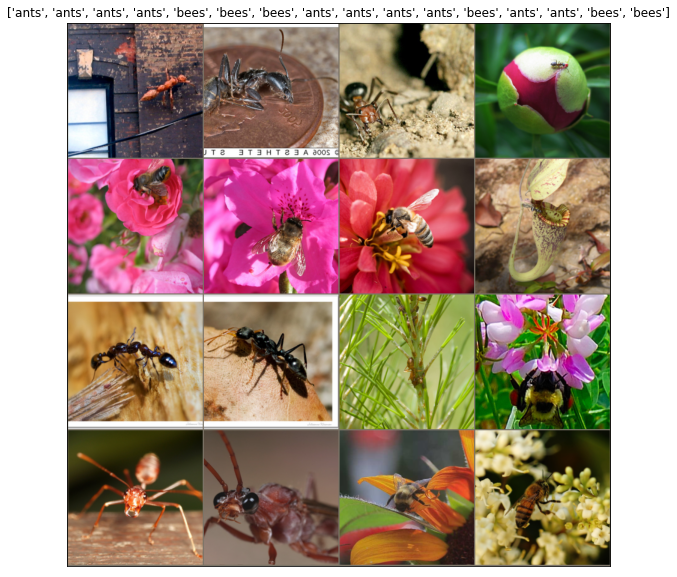

In [86]:
import torchvision

def imshow(inp, title=None, ax=None, figsize=(5, 5)):
  """Imshow for Tensor."""
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  if ax is None:
    fig, ax = plt.subplots(1, figsize=figsize)
  ax.imshow(inp)
  ax.set_xticks([])
  ax.set_yticks([])
  if title is not None:
    ax.set_title(title)

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs, nrow=4)

fig, ax = plt.subplots(1, figsize=(10, 10))
imshow(out, title=[class_names[x] for x in classes], ax=ax)

In [87]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, device='cpu'):
  """
  Support function for model training.

  Args:
    model: Model to be trained
    criterion: Optimization criterion (loss)
    optimizer: Optimizer to use for training
    scheduler: Instance of ``torch.optim.lr_scheduler``
    num_epochs: Number of epochs
    device: Device to run the training on. Must be 'cpu' or 'cuda'
  """
  since = time.time()

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()  # Set model to training mode
      else:
        model.eval()   # Set model to evaluate mode

      running_loss = 0.0
      running_corrects = 0

      # Iterate over data.
      for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        # track history if only in train
        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          loss = criterion(outputs, labels)

          # backward + optimize only if in training phase
          if phase == 'train':
            loss.backward()
            optimizer.step()

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
      if phase == 'train':
        scheduler.step()

      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double() / dataset_sizes[phase]

      print('{} Loss: {:.4f} Acc: {:.4f}'.format(
        phase, epoch_loss, epoch_acc))

      # deep copy the model
      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())

    print()

  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
  print('Best val Acc: {:4f}'.format(best_acc))

  # load best model weights
  model.load_state_dict(best_model_wts)
  return model

In [88]:
def visualize_model(model, rows=3, cols=3):
  was_training = model.training
  model.eval()
  current_row = current_col = 0
  fig, ax = plt.subplots(rows, cols, figsize=(cols*2, rows*2))

  with torch.no_grad():
    for idx, (imgs, lbls) in enumerate(dataloaders['val']):
      imgs = imgs.cpu()
      lbls = lbls.cpu()

      outputs = model(imgs)
      _, preds = torch.max(outputs, 1)

      for jdx in range(imgs.size()[0]):
        imshow(imgs.data[jdx], ax=ax[current_row, current_col])
        ax[current_row, current_col].axis('off')
        ax[current_row, current_col].set_title('predicted: {}'.format(class_names[preds[jdx]]))

        current_col += 1
        if current_col >= cols:
          current_row += 1
          current_col = 0
        if current_row >= rows:
          model.train(mode=was_training)
          return
    model.train(mode=was_training)

In [89]:
import torchvision.models.quantization as models

# You will need the number of filters in the `fc` for future use.
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_fe = models.resnet18(pretrained=True, progress=True, quantize=True)
num_ftrs = model_fe.fc.in_features

C:\Users\jatin\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\jatin\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_QuantizedWeights.IMAGENET1K_FBGEMM_V1`. You can also use `weights=ResNet18_QuantizedWeights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/quantized/resnet18_fbgemm_16fa66dd.pth" to C:\Users\jatin/.cache\torch\hub\checkpoints\resnet18_fbgemm_16fa66dd.pth


  0%|          | 0.00/11.2M [00:00<?, ?B/s]

In [90]:
from torch import nn

def create_combined_model(model_fe):
  # Step 1. Isolate the feature extractor.
  model_fe_features = nn.Sequential(
    model_fe.quant,  # Quantize the input
    model_fe.conv1,
    model_fe.bn1,
    model_fe.relu,
    model_fe.maxpool,
    model_fe.layer1,
    model_fe.layer2,
    model_fe.layer3,
    model_fe.layer4,
    model_fe.avgpool,
    model_fe.dequant,  # Dequantize the output
  )

  # Step 2. Create a new "head"
  new_head = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(num_ftrs, 2),
  )

  # Step 3. Combine, and don't forget the quant stubs.
  new_model = nn.Sequential(
    model_fe_features,
    nn.Flatten(1),
    new_head,
  )
  return new_model

In [91]:
import torch.optim as optim
new_model = create_combined_model(model_fe)
new_model = new_model.to('cpu')

criterion = nn.CrossEntropyLoss()

# Note that we are only training the head.
optimizer_ft = optim.SGD(new_model.parameters(), lr=0.01, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Epoch 0/24
----------
train Loss: 0.4684 Acc: 0.8115
val Loss: 0.1464 Acc: 0.9477

Epoch 1/24
----------
train Loss: 0.3372 Acc: 0.8934
val Loss: 0.1793 Acc: 0.9346

Epoch 2/24
----------
train Loss: 0.2722 Acc: 0.9426
val Loss: 0.6601 Acc: 0.8366

Epoch 3/24
----------
train Loss: 0.5448 Acc: 0.8852
val Loss: 0.2470 Acc: 0.9281

Epoch 4/24
----------
train Loss: 0.4044 Acc: 0.9139
val Loss: 0.3350 Acc: 0.9412

Epoch 5/24
----------
train Loss: 0.2869 Acc: 0.9262
val Loss: 0.3528 Acc: 0.9281

Epoch 6/24
----------
train Loss: 0.4808 Acc: 0.9180
val Loss: 0.3127 Acc: 0.9542

Epoch 7/24
----------
train Loss: 0.3024 Acc: 0.9385
val Loss: 0.3312 Acc: 0.9542

Epoch 8/24
----------
train Loss: 0.2784 Acc: 0.9508
val Loss: 0.3280 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.2098 Acc: 0.9426
val Loss: 0.2988 Acc: 0.9542

Epoch 10/24
----------
train Loss: 0.1878 Acc: 0.9631
val Loss: 0.3177 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.1942 Acc: 0.9590
val Loss: 0.3265 Acc: 0.9477

Ep

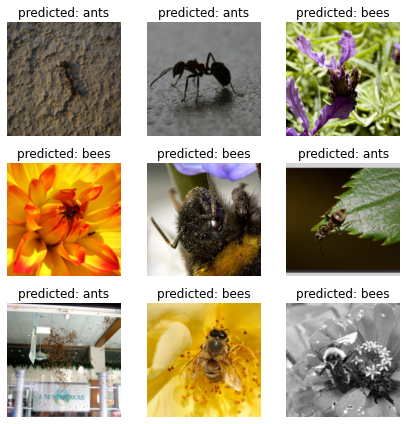

In [92]:
new_model = train_model(new_model, criterion, optimizer_ft, exp_lr_scheduler,
                        num_epochs=25, device='cpu')

visualize_model(new_model)
plt.tight_layout()

In [93]:
# notice `quantize=False`
model = models.resnet18(pretrained=True, progress=True, quantize=False)
num_ftrs = model.fc.in_features

# Step 1
model.train()
model.fuse_model()
# Step 2
model_ft = create_combined_model(model)
model_ft[0].qconfig = torch.quantization.default_qat_qconfig  # Use default QAT configuration
# Step 3
model_ft = torch.quantization.prepare_qat(model_ft, inplace=True)

C:\Users\jatin\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\jatin\anaconda3\lib\site-packages\torch\ao\quantization\observer.py:176: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


In [94]:
for param in model_ft.parameters():
  param.requires_grad = True

model_ft.to(device)  # We can fine-tune on GPU if available

criterion = nn.CrossEntropyLoss()

# Note that we are training everything, so the learning rate is lower
# Notice the smaller learning rate
optimizer_ft = optim.SGD(model_ft.parameters(), lr=1e-3, momentum=0.9, weight_decay=0.1)

# Decay LR by a factor of 0.3 every several epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.3)

model_ft_tuned = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                             num_epochs=25, device=device)

Epoch 0/24
----------
train Loss: 0.6691 Acc: 0.6311
val Loss: 0.3363 Acc: 0.8889

Epoch 1/24
----------
train Loss: 0.2972 Acc: 0.8770
val Loss: 0.2088 Acc: 0.9281

Epoch 2/24
----------
train Loss: 0.1792 Acc: 0.9467
val Loss: 0.1862 Acc: 0.9281

Epoch 3/24
----------
train Loss: 0.1623 Acc: 0.9344
val Loss: 0.1707 Acc: 0.9346

Epoch 4/24
----------
train Loss: 0.1366 Acc: 0.9631
val Loss: 0.1618 Acc: 0.9412

Epoch 5/24
----------
train Loss: 0.0808 Acc: 0.9795
val Loss: 0.1805 Acc: 0.9346

Epoch 6/24
----------
train Loss: 0.0781 Acc: 0.9754
val Loss: 0.1769 Acc: 0.9281

Epoch 7/24
----------
train Loss: 0.0723 Acc: 0.9959
val Loss: 0.1799 Acc: 0.9281

Epoch 8/24
----------
train Loss: 0.0825 Acc: 0.9836
val Loss: 0.1903 Acc: 0.9216

Epoch 9/24
----------
train Loss: 0.1065 Acc: 0.9672
val Loss: 0.1495 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.0484 Acc: 0.9918
val Loss: 0.1532 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.0575 Acc: 0.9877
val Loss: 0.1563 Acc: 0.9412

Ep

In [95]:
from torch.quantization import convert
model_ft_tuned.cpu()

model_quantized_and_trained = convert(model_ft_tuned, inplace=False)

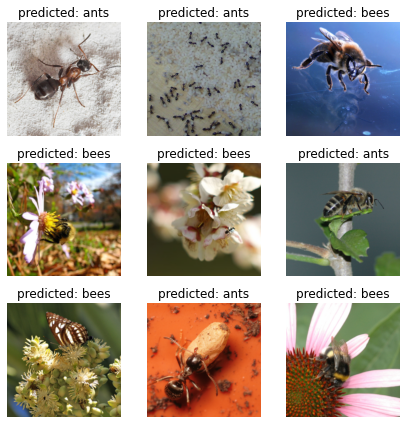

In [96]:
visualize_model(model_quantized_and_trained)

plt.ioff()
plt.tight_layout()
plt.show()